In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
df = pd.read_csv('population.csv')
df.head()

,year,pop,pop2
0,1950,2.53,0.557959
1,1951,2.57,0.861880
2,1952,2.62,0.747475
3,1953,2.67,0.801511
4,1954,2.71,0.851062


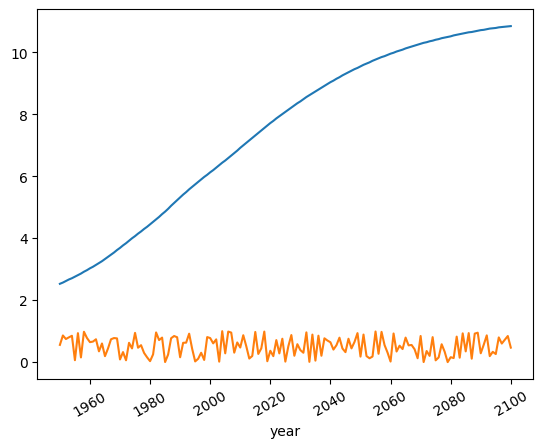

In [ ]:
df2 = df.set_index('year')
df2.plot(legend=None)
plt.xticks(rotation=30);
# 橘 pop 、藍 pop2

In [ ]:
df2.head()

,pop,pop2
year,,
1950,2.53,0.557959
1951,2.57,0.861880
1952,2.62,0.747475
1953,2.67,0.801511
1954,2.71,0.851062


In [ ]:
df2.tail()

,pop,pop2
year,,
2096,10.81,0.798702
2097,10.82,0.600868
2098,10.83,0.720714
2099,10.84,0.844270
2100,10.85,0.469745


In [ ]:
len(df2)

151

In [ ]:
from sklearn.preprocessing import MinMaxScaler
look_back = 1 # 以前N期资料为 X，当期资料为 Y

# 函数：以前N期资料为 X，当前期资料为 Y
def create_dataset(data1, look_back):
    x, y = [], []
    for i in range(len(data1)-look_back-1):
        _x = data1[i:(i+look_back)]
        _y = data1[i+look_back, 1:2]
        print(f'this {i} round', _x, _y)
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

dataset = df2[['pop', 'pop2']].values.astype('float32')

# X 常态化
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

# 资料分割
train_size = int(len(dataset) * 0.1) # int(151 * 0.1) => 15 : train_size
test_size = len(dataset) - train_size # test_size = 151 - 15 = 136
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)
dataset.shape#, trainY.shape, testY.shape,trainX.shape

this 0 round [[0.        0.5573713]] [0.8618545]
this 1 round [[0.00480768 0.8618545 ]] [0.7472375]
this 2 round [[0.01081729 0.7472375 ]] [0.8013733]
this 3 round [[0.01682693 0.8013733 ]] [0.8510159]
this 4 round [[0.02163461 0.8510159 ]] [0.06202664]
this 5 round [[0.02764422 0.06202664]] [0.93627787]
this 6 round [[0.03365386 0.93627787]] [0.15169778]
this 7 round [[0.03966346 0.15169778]] [0.9813841]
this 8 round [[0.046875  0.9813841]] [0.7808319]
this 9 round [[0.05288461 0.7808319 ]] [0.6458696]
this 10 round [[0.06009614 0.6458696 ]] [0.6639264]
this 11 round [[0.06610575 0.6639264 ]] [0.7386251]
this 12 round [[0.07331732 0.7386251 ]] [0.34845677]
this 0 round [[0.09615383 0.19263187]] [0.4389116]
this 1 round [[0.10456732 0.4389116 ]] [0.73858386]
this 2 round [[0.11298075 0.73858386]] [0.7782367]
this 3 round [[0.12139422 0.7782367 ]] [0.76726466]
this 4 round [[0.13100961 0.76726466]] [0.08639757]
this 5 round [[0.13942307 0.08639757]] [0.32415608]
this 6 round [[0.1490384

(151, 2)

In [ ]:
# look_back = 1
trainX.shape, trainY.shape, testX.shape, testY.shape, trainX[1].shape

(torch.Size([13, 1, 2]),
 torch.Size([13, 1]),
 torch.Size([134, 1, 2]),
 torch.Size([134, 1]),
 torch.Size([1, 2]))

# Many to One

In [122]:
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size=4, num_layers=1): # hiddn_size = 4，output會變4個node， 1層lstm, batch_first = True -> input (N sequence length, L look_back, H)
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(2, self.hidden_size, num_layers=self.num_layers, batch_first=True) # nn.LSTM(input_size input-dim, hidden_size hidden-dim, num_layers, batch_first)
        self.fc = nn.Linear(self.hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        print('x.shape',x.shape)
        # rnn_out, h_out = self.rnn(x)
        # 初始化
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        print('out: ',out.shape)
        print('out value: ',out)
        print('out-1: ',out[-1].shape)
        print('out-1 value: ',out[-1])
        print('h_out: ',h_out.shape)
        print('h_out value: ',h_out)
        print('h_out[-1]: ',h_out[-1].shape)
        print('h_out[-1][-1] value: ',h_out[-1,-1])
        # output 的最後一層就是ht

        # 取最后一层的 h，并转成二维
        h_out = h_out[-1].view(-1, self.hidden_size)
        print('h_out-1: ',h_out.shape)

        return self.fc(h_out)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)

In [123]:
trainX

tensor([[[0.0000, 0.5574]],

        [[0.0048, 0.8619]],

        [[0.0108, 0.7472]],

        [[0.0168, 0.8014]],

        [[0.0216, 0.8510]],

        [[0.0276, 0.0620]],

        [[0.0337, 0.9363]],

        [[0.0397, 0.1517]],

        [[0.0469, 0.9814]],

        [[0.0529, 0.7808]],

        [[0.0601, 0.6459]],

        [[0.0661, 0.6639]],

        [[0.0733, 0.7386]]])

In [124]:
num_epochs = 1
learning_rate = 0.01


def train(trainX, trainY):
    criterion = torch.nn.MSELoss()  # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(trainX) #model是上面定義的LSTM架構

        if epoch <= 0: print(outputs.shape)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

train(trainX, trainY)

x.shape torch.Size([13, 1, 2])
out:  torch.Size([13, 1, 4])
out value:  tensor([[[-0.0745,  0.0444,  0.0459,  0.0604]],

        [[-0.0916,  0.0744,  0.0586,  0.0729]],

        [[-0.0864,  0.0624,  0.0533,  0.0682]],

        [[-0.0897,  0.0677,  0.0553,  0.0700]],

        [[-0.0925,  0.0726,  0.0573,  0.0716]],

        [[-0.0389,  0.0006,  0.0254,  0.0299]],

        [[-0.0973,  0.0810,  0.0604,  0.0740]],

        [[-0.0477,  0.0068,  0.0281,  0.0350]],

        [[-0.1003,  0.0853,  0.0618,  0.0748]],

        [[-0.0916,  0.0639,  0.0526,  0.0671]],

        [[-0.0848,  0.0499,  0.0464,  0.0609]],

        [[-0.0864,  0.0514,  0.0469,  0.0613]],

        [[-0.0911,  0.0586,  0.0497,  0.0642]]], grad_fn=<TransposeBackward0>)
out-1:  torch.Size([1, 4])
out-1 value:  tensor([[-0.0911,  0.0586,  0.0497,  0.0642]], grad_fn=<SelectBackward0>)
h_out:  torch.Size([1, 13, 4])
h_out value:  tensor([[[-0.0745,  0.0444,  0.0459,  0.0604],
         [-0.0916,  0.0744,  0.0586,  0.0729],
       

In [125]:
model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()
trainPredict.shape

x.shape torch.Size([13, 1, 2])
out:  torch.Size([13, 1, 4])
out value:  tensor([[[-0.0809,  0.0505,  0.0536,  0.0546]],

        [[-0.0985,  0.0821,  0.0678,  0.0666]],

        [[-0.0932,  0.0696,  0.0620,  0.0620]],

        [[-0.0965,  0.0752,  0.0643,  0.0637]],

        [[-0.0994,  0.0804,  0.0665,  0.0653]],

        [[-0.0442,  0.0043,  0.0310,  0.0252]],

        [[-0.1044,  0.0893,  0.0701,  0.0675]],

        [[-0.0533,  0.0109,  0.0340,  0.0300]],

        [[-0.1075,  0.0939,  0.0717,  0.0683]],

        [[-0.0986,  0.0715,  0.0616,  0.0608]],

        [[-0.0917,  0.0568,  0.0548,  0.0548]],

        [[-0.0933,  0.0584,  0.0553,  0.0552]],

        [[-0.0981,  0.0661,  0.0585,  0.0580]]], grad_fn=<TransposeBackward0>)
out-1:  torch.Size([1, 4])
out-1 value:  tensor([[-0.0981,  0.0661,  0.0585,  0.0580]], grad_fn=<SelectBackward0>)
h_out:  torch.Size([1, 13, 4])
h_out value:  tensor([[[-0.0809,  0.0505,  0.0536,  0.0546],
         [-0.0985,  0.0821,  0.0678,  0.0666],
       

(13, 1)

In [126]:
trainY.shape, trainPredict.shape

(torch.Size([13, 1]), (13, 1))

# Many to Many

In [127]:
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size=4, num_layers=1): # hiddn_size = 4，output會變4個node， 1層lstm, batch_first = True -> input (N sequence length, L look_back, H)
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(2, self.hidden_size, num_layers=self.num_layers, batch_first=True) # nn.LSTM(input_size input-dim, hidden_size hidden-dim, num_layers, batch_first)
        self.fc = nn.Linear(self.hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        print('x.shape',x.shape)
        # rnn_out, h_out = self.rnn(x)
        # 初始化
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        print('out: ',out.shape)
        print('out value: ',out)
        # print('out-1: ',out[-1].shape)
        # print('out-1 value: ',out[-1])
        # print('h_out: ',h_out.shape)
        # print('h_out value: ',h_out)
        # print('h_out[-1]: ',h_out[-1].shape)
        # print('h_out[-1][-1] value: ',h_out[-1,-1])

        return self.fc(out)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)

In [128]:
model

TimeSeriesModel(
  (rnn): LSTM(2, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [129]:
print(trainX.shape)
print(trainX)

torch.Size([13, 1, 2])
tensor([[[0.0000, 0.5574]],

        [[0.0048, 0.8619]],

        [[0.0108, 0.7472]],

        [[0.0168, 0.8014]],

        [[0.0216, 0.8510]],

        [[0.0276, 0.0620]],

        [[0.0337, 0.9363]],

        [[0.0397, 0.1517]],

        [[0.0469, 0.9814]],

        [[0.0529, 0.7808]],

        [[0.0601, 0.6459]],

        [[0.0661, 0.6639]],

        [[0.0733, 0.7386]]])


In [130]:
num_epochs = 1
learning_rate = 0.01


def train(trainX, trainY):
    criterion = torch.nn.MSELoss()  # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(trainX) #model是上面定義的LSTM架構

        if epoch <= 0: print('This is outputs shape', outputs.shape)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

train(trainX, trainY)

x.shape torch.Size([13, 1, 2])
out:  torch.Size([13, 1, 4])
out value:  tensor([[[ 0.0514, -0.0228, -0.0569,  0.0142]],

        [[ 0.0608, -0.0204, -0.0677,  0.0203]],

        [[ 0.0579, -0.0211, -0.0643,  0.0184]],

        [[ 0.0597, -0.0205, -0.0665,  0.0196]],

        [[ 0.0613, -0.0200, -0.0683,  0.0207]],

        [[ 0.0350, -0.0258, -0.0389,  0.0047]],

        [[ 0.0641, -0.0191, -0.0716,  0.0227]],

        [[ 0.0393, -0.0248, -0.0436,  0.0071]],

        [[ 0.0658, -0.0185, -0.0736,  0.0240]],

        [[ 0.0610, -0.0198, -0.0679,  0.0205]],

        [[ 0.0575, -0.0205, -0.0639,  0.0181]],

        [[ 0.0583, -0.0202, -0.0649,  0.0187]],

        [[ 0.0608, -0.0195, -0.0678,  0.0204]]], grad_fn=<TransposeBackward0>)
This is outputs shape torch.Size([13, 1, 1])
Epoch: 0, loss: 0.50444


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [131]:
model.eval()
trainPredict = model(trainX).detach().numpy()
testPredict = model(testX).detach().numpy()
trainPredict.shape

x.shape torch.Size([13, 1, 2])
out:  torch.Size([13, 1, 4])
out value:  tensor([[[ 0.0415, -0.0272, -0.0629,  0.0100]],

        [[ 0.0501, -0.0250, -0.0744,  0.0155]],

        [[ 0.0475, -0.0256, -0.0708,  0.0137]],

        [[ 0.0492, -0.0251, -0.0731,  0.0148]],

        [[ 0.0507, -0.0247, -0.0750,  0.0158]],

        [[ 0.0264, -0.0298, -0.0436,  0.0013]],

        [[ 0.0532, -0.0238, -0.0784,  0.0176]],

        [[ 0.0304, -0.0289, -0.0486,  0.0034]],

        [[ 0.0549, -0.0232, -0.0805,  0.0188]],

        [[ 0.0504, -0.0243, -0.0745,  0.0156]],

        [[ 0.0472, -0.0250, -0.0702,  0.0135]],

        [[ 0.0480, -0.0247, -0.0712,  0.0140]],

        [[ 0.0503, -0.0241, -0.0743,  0.0155]]], grad_fn=<TransposeBackward0>)
x.shape torch.Size([134, 1, 2])
out:  torch.Size([134, 1, 4])
out value:  tensor([[[ 0.0352, -0.0270, -0.0546,  0.0060]],

        [[ 0.0436, -0.0252, -0.0652,  0.0111]],

        [[ 0.0522, -0.0231, -0.0766,  0.0168]],

        [[ 0.0535, -0.0226, -0.0783,  0.

(13, 1, 1)

In [132]:
trainY.shape, trainPredict.shape

(torch.Size([13, 1]), (13, 1, 1))